<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [4]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [24]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

`batch_size` влияет на общее время обучения, время обучения на единицу времени, качество модели. Чем больше `batch_size`, тем быстрее обучается модель, но ее качество может снизиться. Поэтому важен баланс.

Посмотрим на какую-нибудь картинку:

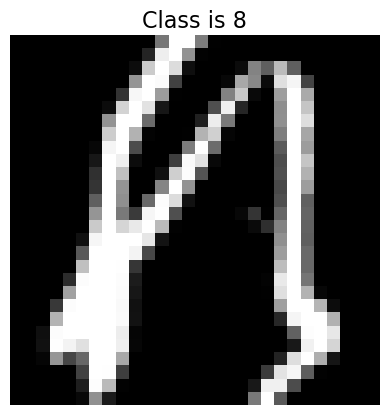

In [6]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





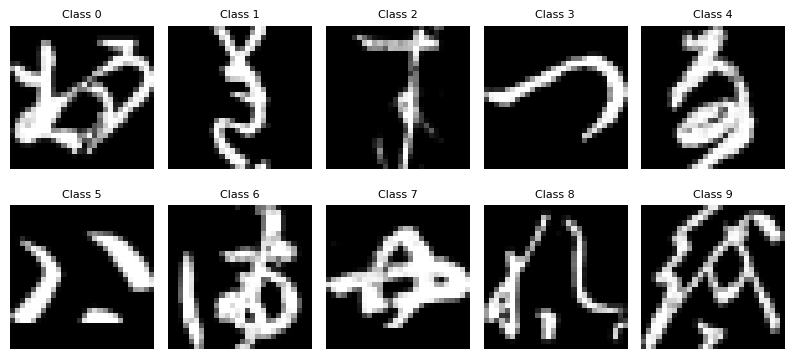

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 7))
for i, ax in enumerate(axs.ravel()):
    a = i
    while trainset[a][1] != i:
        a += 1
    ax.imshow(trainset[a][0].view(28, 28).numpy(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Class {trainset[a][1]}", fontsize=8)

plt.subplots_adjust(wspace=0.1, hspace=-0.5)
plt.show();

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [16]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE

        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = nn.LeakyReLU()


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [20]:
n_parameters = (28*28*256 + 256*128 + 128*10) + (256 + 128 + 10)
print(f'The answer is {n_parameters}')

The answer is 235146


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [39]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [40]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [41]:
def train_model(n_epochs, dataloader):
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in dataloader:
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        loss_history.append(epoch_loss / len(dataloader))

        print(f"Epoch {epoch + 1} - Loss: {loss_history[epoch]:.4f}")

    return loss_history

In [42]:
n_epochs = 10
loss_history = train_model(n_epochs, trainloader)

Epoch 1 - Loss: 0.6959
Epoch 2 - Loss: 0.3034
Epoch 3 - Loss: 0.2223
Epoch 4 - Loss: 0.1732
Epoch 5 - Loss: 0.1382
Epoch 6 - Loss: 0.1113
Epoch 7 - Loss: 0.0906
Epoch 8 - Loss: 0.0756
Epoch 9 - Loss: 0.0618
Epoch 10 - Loss: 0.0493


In [43]:
get_accuracy(fc_net, testloader)

0.8902

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [45]:
mean = torch.mean(next(iter(trainloader))[0]) ## calculate mean
std = torch.std(next(iter(trainloader))[0]) ## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1907) tensor(0.3537)


In [46]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [47]:
n_epochs = 10
loss_history_norm = train_model(n_epochs, trainloader)

Epoch 1 - Loss: 0.6828
Epoch 2 - Loss: 0.3039
Epoch 3 - Loss: 0.2253
Epoch 4 - Loss: 0.1762
Epoch 5 - Loss: 0.1418
Epoch 6 - Loss: 0.1149
Epoch 7 - Loss: 0.0943
Epoch 8 - Loss: 0.0771
Epoch 9 - Loss: 0.0637
Epoch 10 - Loss: 0.0517


In [48]:
get_accuracy(fc_net, testloader)

0.8971

Как изменилась `accuracy` после нормализации?

Совсем немного повысилась! 

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
## YOUR CODE HERE

In [66]:
class FCNet_act(nn.Module):
    def __init__(self, activation):
        super().__init__()

        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = activation
       

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x) 

        return logits

In [67]:
activations = [nn.ReLU(), nn.Sigmoid(), nn.GELU(), nn.Tanh()]

lr = 0.001
n_epochs = 10

for activation in activations:
    print('-'*20)
    print(f'{activation = }')
    fc_net = FCNet_act(activation = activation)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
    
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        
        print(f"Epoch {epoch+1} Loss: {loss_history[epoch]:.4f}")
    print(f"accuracy score: {get_accuracy(fc_net, testloader)}")

--------------------
activation = ReLU()


Epoch 1 Loss: 0.7004
Epoch 2 Loss: 0.3130
Epoch 3 Loss: 0.2294
Epoch 4 Loss: 0.1785
Epoch 5 Loss: 0.1423
Epoch 6 Loss: 0.1148
Epoch 7 Loss: 0.0941
Epoch 8 Loss: 0.0784
Epoch 9 Loss: 0.0641
Epoch 10 Loss: 0.0521
accuracy score: 0.8988
--------------------
activation = Sigmoid()
Epoch 1 Loss: 1.5429
Epoch 2 Loss: 0.7570
Epoch 3 Loss: 0.5478
Epoch 4 Loss: 0.4472
Epoch 5 Loss: 0.3779
Epoch 6 Loss: 0.3247
Epoch 7 Loss: 0.2818
Epoch 8 Loss: 0.2460
Epoch 9 Loss: 0.2162
Epoch 10 Loss: 0.1914
accuracy score: 0.8536
--------------------
activation = GELU(approximate='none')
Epoch 1 Loss: 0.6622
Epoch 2 Loss: 0.2848
Epoch 3 Loss: 0.2068
Epoch 4 Loss: 0.1575
Epoch 5 Loss: 0.1247
Epoch 6 Loss: 0.0997
Epoch 7 Loss: 0.0808
Epoch 8 Loss: 0.0643
Epoch 9 Loss: 0.0518
Epoch 10 Loss: 0.0407
accuracy score: 0.9022
--------------------
activation = Tanh()
Epoch 1 Loss: 0.7666
Epoch 2 Loss: 0.3776
Epoch 3 Loss: 0.2533
Epoch 4 Loss: 0.1819
Epoch 5 Loss: 0.1358
Epoch 6 Loss: 0.1022
Epoch 7 Loss: 0.0779
Epoch 8

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

С использованием `GELU`, на втором месте `tahn`

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [59]:
optimisators  = [torch.optim.Adam, torch.optim.Adagrad, torch.optim.RMSprop]
lr = 0.001
n_epochs = 10

for optimisator in optimisators:
    print('-'*20)
    print(f'{optimisator = }')
    fc_net = FCNet_act(activation = nn.GELU())
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimisator(fc_net.parameters(), lr=3e-4)
    
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        
        print(f"Epoch {epoch+1} - Loss: {loss_history[epoch]:.4f}")
    print(f"accuracy score: {get_accuracy(fc_net, testloader)}")

--------------------
optimisator = <class 'torch.optim.adam.Adam'>
Epoch 1 - Loss: 0.6508
Epoch 2 - Loss: 0.2771
Epoch 3 - Loss: 0.2028
Epoch 4 - Loss: 0.1547
Epoch 5 - Loss: 0.1230
Epoch 6 - Loss: 0.0979
Epoch 7 - Loss: 0.0776
Epoch 8 - Loss: 0.0612
Epoch 9 - Loss: 0.0491
Epoch 10 - Loss: 0.0381
accuracy score: 0.8961
--------------------
optimisator = <class 'torch.optim.adagrad.Adagrad'>
Epoch 1 - Loss: 1.3967
Epoch 2 - Loss: 0.8322
Epoch 3 - Loss: 0.6935
Epoch 4 - Loss: 0.6271
Epoch 5 - Loss: 0.5854
Epoch 6 - Loss: 0.5563
Epoch 7 - Loss: 0.5337
Epoch 8 - Loss: 0.5149
Epoch 9 - Loss: 0.4994
Epoch 10 - Loss: 0.4865
accuracy score: 0.7234
--------------------
optimisator = <class 'torch.optim.rmsprop.RMSprop'>
Epoch 1 - Loss: 0.4440
Epoch 2 - Loss: 0.2431
Epoch 3 - Loss: 0.1787
Epoch 4 - Loss: 0.1389
Epoch 5 - Loss: 0.1091
Epoch 6 - Loss: 0.0857
Epoch 7 - Loss: 0.0675
Epoch 8 - Loss: 0.0530
Epoch 9 - Loss: 0.0404
Epoch 10 - Loss: 0.0312
accuracy score: 0.8972


`RMSprop` - лучшее качество, `Adam` - тоже не плохо, разница маленькая. `Adagrad` - плохо.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [61]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x = torch.maximum(x, torch.tensor([0]))
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [64]:
fc_net = FCNet_act(activation = CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch {epoch+1} - Loss: {loss_history[epoch]:.4f}")
print(f"accuracy score: {get_accuracy(fc_net, testloader)}")

Epoch 1 - Loss: 0.6905
Epoch 2 - Loss: 0.3030
Epoch 3 - Loss: 0.2208
Epoch 4 - Loss: 0.1705
Epoch 5 - Loss: 0.1342
Epoch 6 - Loss: 0.1090
Epoch 7 - Loss: 0.0896
Epoch 8 - Loss: 0.0727
Epoch 9 - Loss: 0.0602
Epoch 10 - Loss: 0.0485
accuracy score: 0.9022


`accuracy score: 0.9022`, у ReLu было `accuracy score: 0.8988`.

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Copilot: нарисуй мне мрачное будущее

![alt text](OIG2.jpg)

Добавь мутантов и радиоактивные озера

![alt text](OIG1.LY1.mvwOfwKfE3Yi.jpg)

Добавь паладина Братства Стали и гулей

![alt text](OIG1.jpg)